In [1]:
#!git clone https://github.com/pieper/dicomsort.git
!pip install pydicom
#!python dicomsort/dicomsort.py --help

In [2]:
!pip install pylidc

     |████████████████████████████████| 5.6 MB 6.8 MB/s eta 0:00:01
     |████████████████████████████████| 30.2 MB 66.1 MB/s eta 0:00:01
     |████████████████████████████████| 10.3 MB 68.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.5 MB 66.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 65.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 62.3 MB/s eta 0:00:01
     |████████████████████████████████| 171 kB 75.0 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 73.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 45.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 79.7 MB/s eta 0:00:01
     |████████████████████████████████| 150 kB 93.0 MB/s eta 0:00:01


In [3]:
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
#import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
#import pandas as pd

In [4]:
pl.query(pl.Scan).count()
pid = 'LIDC-IDRI-0001'
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
scan.study_instance_uid

'1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288633453246975630178'

In [5]:
myProjectID = "idc-external-012"

In [6]:
import os
data_folder = os.getcwd() + '/cohort_sorted_3/'
print("data_folder = {}".format(data_folder))
#f = open ('.pylidcrc','w')            #For GCP
f = open ('/root/.pylidcrc','w')    #For Colab
f.write('[dicom]'+'\n')
f.write('path =' + data_folder +'\n')
f.write('warn = True')
f.close()

data_folder = /app/cohort_sorted_3/


Current patient ID = LIDC-IDRI-0098
Loading dicom files ... This may take a moment.


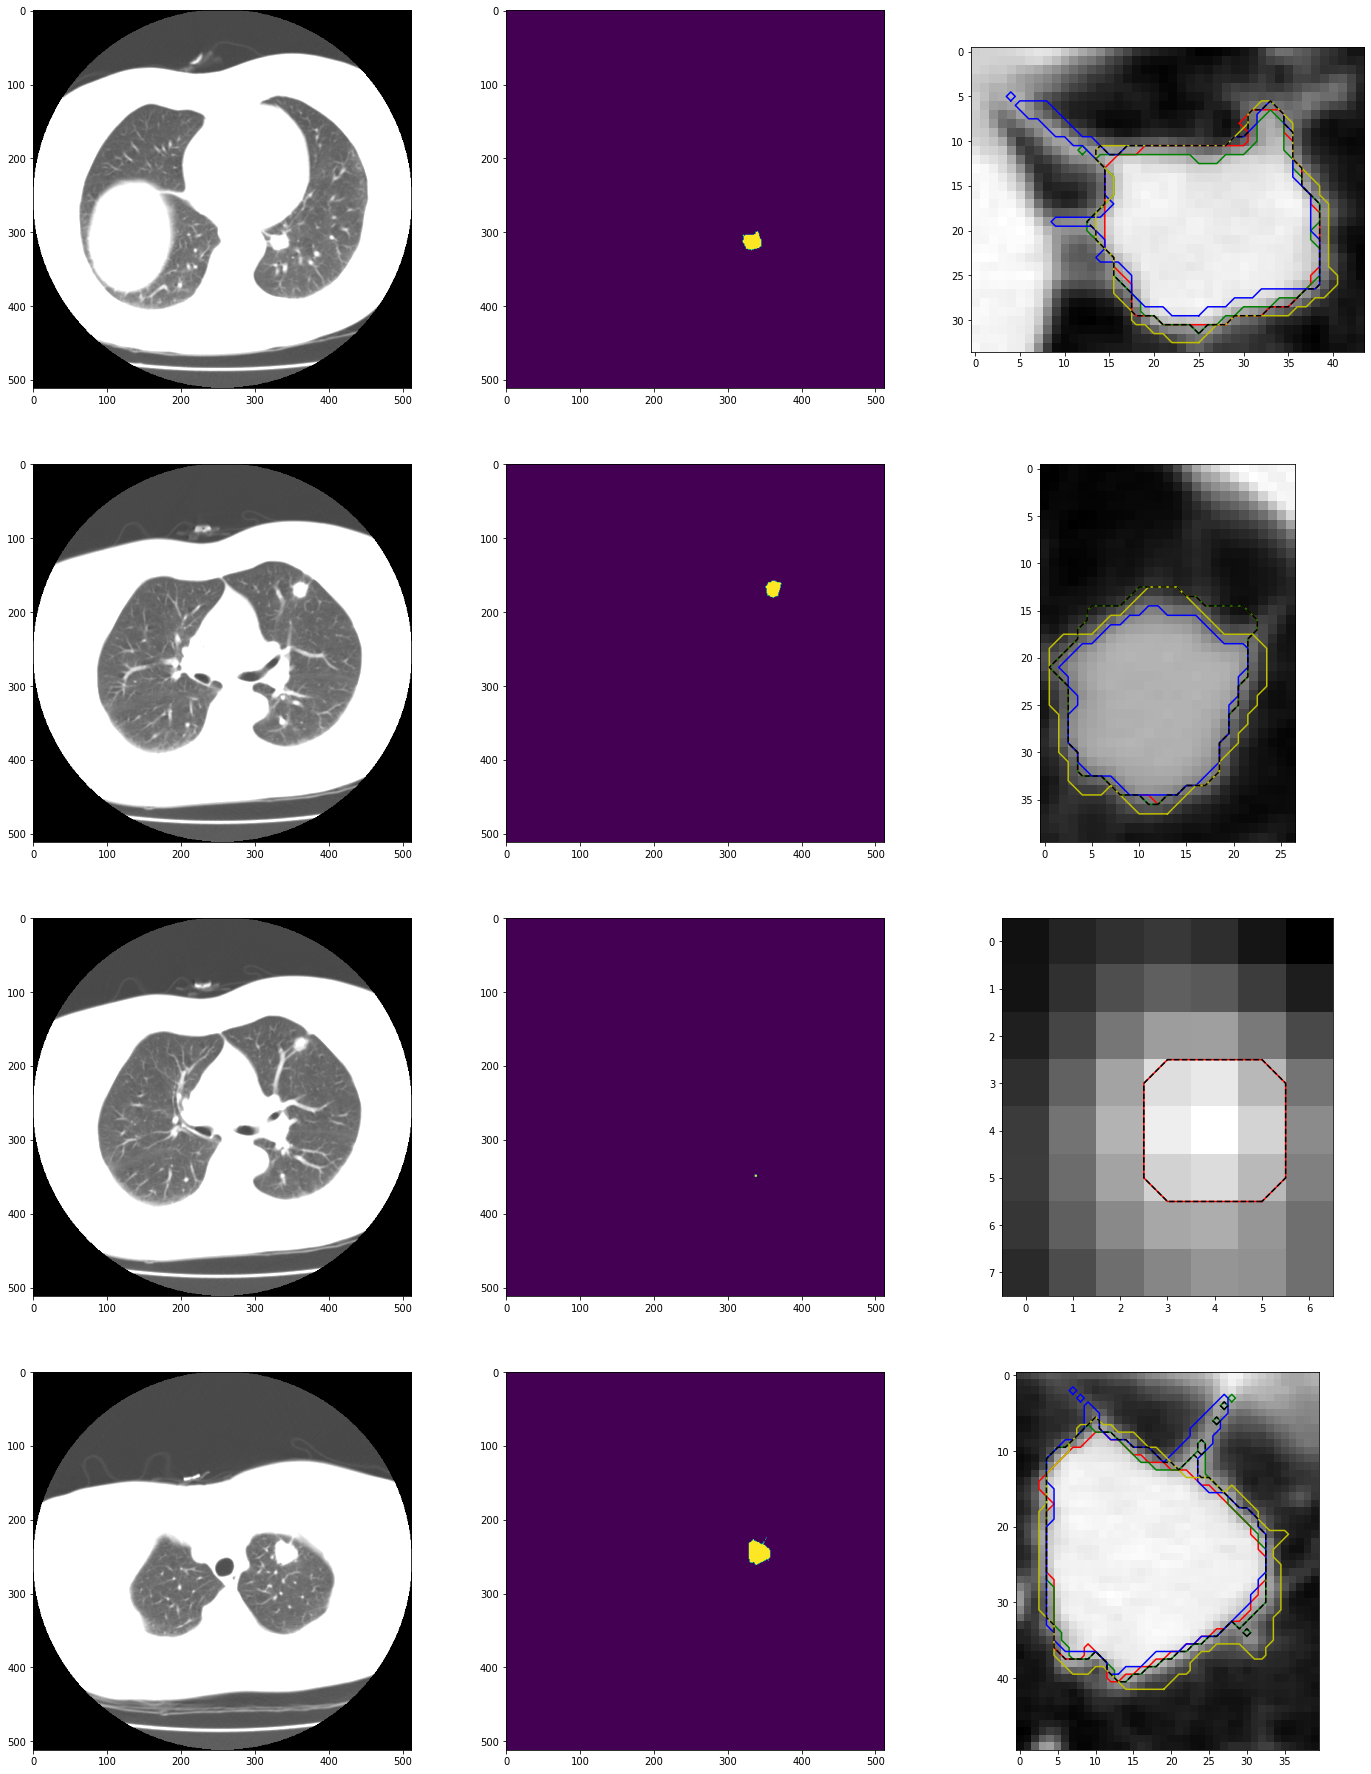

In [7]:
%matplotlib inline

cohort = data_folder
patient_list = os.listdir(cohort)
patient_select = 0

print ("Current patient ID =", patient_list[patient_select])

scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(patient_list))
nodules_annotation = scan[patient_select].cluster_annotations()
vol = scan[patient_select].to_volume()

cmask_CT = []
cbbox_CT = []
masks_CT = []
for nodule_idx, nodule in enumerate(nodules_annotation):
    cmask, cbbox, masks = consensus(nodule)
    cmask_CT.append(cmask)
    cbbox_CT.append(cbbox)
    masks_CT.append(masks)   

nodule_num = len(cmask_CT)
plt.figure(figsize=(8*3,8*nodule_num))
for i in range(nodule_num):
    cmask = cmask_CT[i]
    cbbox = cbbox_CT[i]
    masks = masks_CT[i]
    k = int(0.5*(cbbox[2].stop - cbbox[2].start))
    k_slice = k + cbbox[2].start
    plt.subplot(nodule_num,3,1+i*3)
    plt.imshow(vol[:,:,k_slice],cmap='gray')
    plt.clim(vmin=-1350,vmax=-150)
    
    plt.subplot(nodule_num,3,2+i*3)
    CT_mask = np.zeros_like(vol)
    CT_mask[cbbox] = cmask
    plt.imshow(CT_mask[:,:,k_slice])

    plt.subplot(nodule_num,3,3+i*3)
    plt.imshow(vol[cbbox][:,:,k],cmap='gray')
    # Plot the annotation contours for the kth slice.
    colors = ['r', 'g', 'b', 'y']
    for j in range(len(masks)):
        for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
            label = "Annotation %d" % (j+1)
            plt.plot(c[:,1], c[:,0], colors[j], label=label)

    # Plot the 50% consensus contour for the kth slice.
    for c in find_contours(cmask[:,:,k].astype(float), 0.5):
        plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')

### Load the CT images in memory

In [8]:

CT_image_data = []
CT_mask_data  = []

for pa in range(len(patient_list)):
    print ("Current patient ID =", patient_list[pa])
    
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(patient_list))
    nodules_annotation = scan[pa].cluster_annotations()
    vol = scan[pa].to_volume()
    
    CT_image_data.append(vol)
    
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)   

    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)
    print("Length of nodules = {}".format(nodule_num))
    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]    
        CT_mask[cbbox] += cmask
        print("Unique labels in mask = {}".format(np.unique(CT_mask[cbbox])))
        
    CT_mask_data.append(CT_mask)

Current patient ID = LIDC-IDRI-0098
Loading dicom files ... This may take a moment.
Length of nodules = 4
Unique labels in mask = [0 1]
Unique labels in mask = [0 1]
Unique labels in mask = [0 1]
Unique labels in mask = [0 1]
Current patient ID = LIDC-IDRI-0086
Loading dicom files ... This may take a moment.
Length of nodules = 3
Unique labels in mask = [0 1]
Unique labels in mask = [0 1]
Unique labels in mask = [0 1]
Current patient ID = LIDC-IDRI-0084
Loading dicom files ... This may take a moment.
Length of nodules = 1
Unique labels in mask = [0 1]
Current patient ID = LIDC-IDRI-0325
Loading dicom files ... This may take a moment.
Length of nodules = 1
Unique labels in mask = [0 1]
Current patient ID = LIDC-IDRI-0106
Loading dicom files ... This may take a moment.
Length of nodules = 6
Unique labels in mask = [0 1]
Unique labels in mask = [0 1]
Unique labels in mask = [0 1]
Unique labels in mask = [0 1]
Unique labels in mask = [0 1]
Unique labels in mask = [0 1]
Current patient ID =

In [75]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
from IPython import display

### Prepare the dataset

In [232]:
def normalize(input_image):#, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    #input_mask -= 1
    return input_image#, input_mask

def load_image(CT_image_data, CT_mask_data):
    #use nearest, to prevent the labels from changing
    input_image = tf.image.resize(CT_image_data, (128, 128), method='nearest')
    #input_mask = tf.image.resize(CT_mask_data, (128, 128), method='nearest')
    input_mask = tf.image.resize(CT_mask_data, (128, 128), method='nearest')

    input_image = normalize(input_image)

    return input_image, input_mask

In [233]:
# alternate, for more than one patient
# get the dataset generator
def get_train_data_generator_bodytext(CT_image_data, CT_mask_data):
    for i in range(len(CT_image_data)):
        for j in range(CT_image_data[i].shape[2]):
            image, mask = load_image(tf.expand_dims(CT_image_data[i][:,:,j], -1), tf.expand_dims(CT_mask_data[i][:,:,j], -1))
            yield image, mask
        # yield image, mask
def get_train_dataset(CT_image_data, CT_mask_data):
    generator = lambda: get_train_data_generator_bodytext(CT_image_data, CT_mask_data)
    return tf.data.Dataset.from_generator(
        generator, output_signature=(
            tf.TensorSpec(shape=(128, 128, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(128, 128, 1), dtype=tf.float32)))

In [234]:
ds_train = get_train_dataset(CT_image_data,CT_mask_data)
ds_train.element_spec

(TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))

In [235]:
for d, l in ds_train.take(1):
    print(d.shape)
    print(l.shape)

(128, 128, 1)
(128, 128, 1)


In [236]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        #print(display_list[i])
        plt.imshow(display_list[i])
        #plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(128, 128) (128, 128)


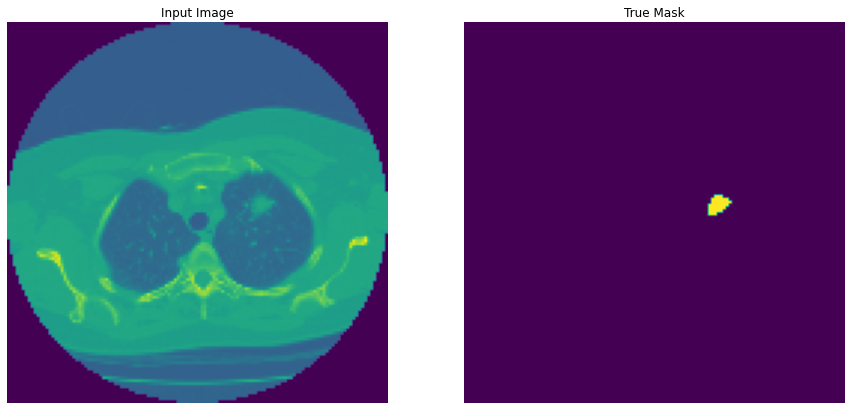

(128, 128) (128, 128)


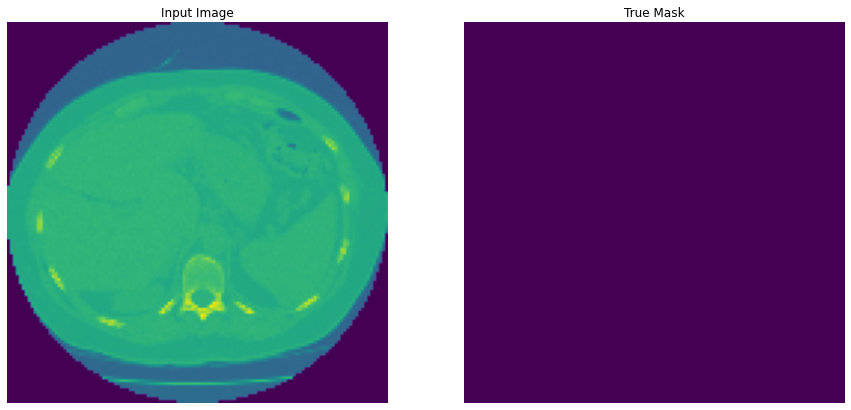

(128, 128) (128, 128)


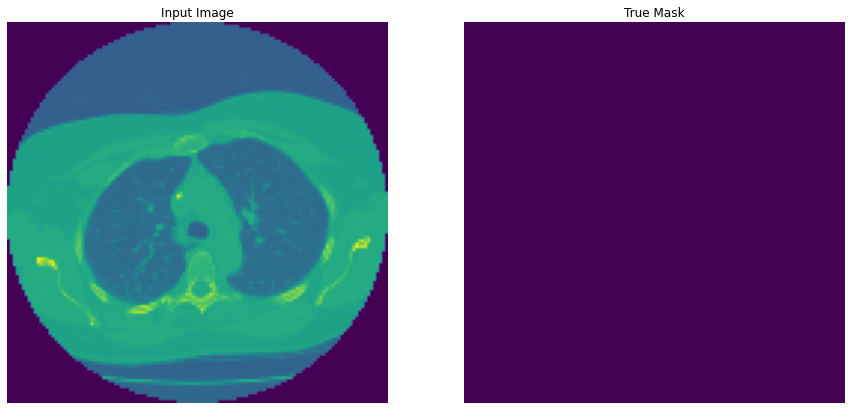

(128, 128) (128, 128)


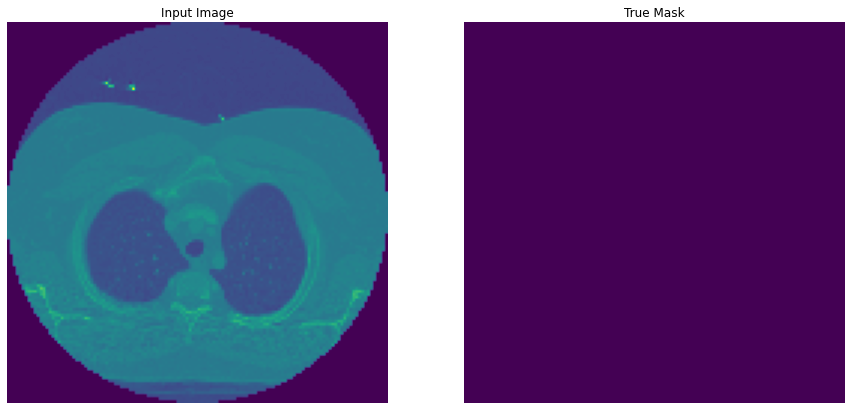

(128, 128) (128, 128)


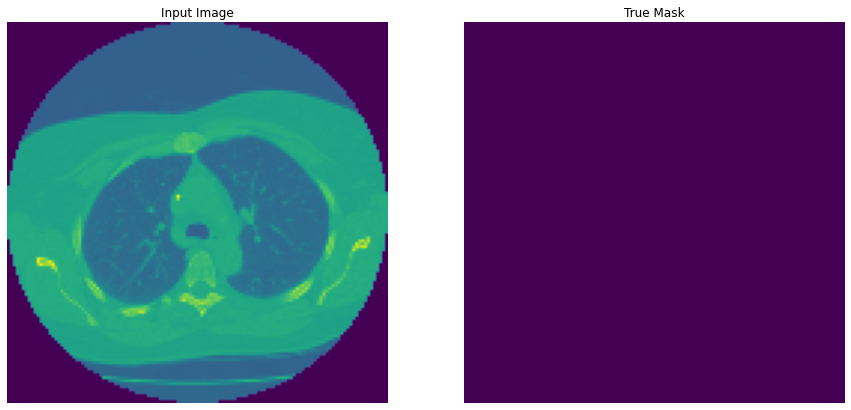

In [126]:
for images, masks in ds_train.shuffle(300).take(5):
    sample_image, sample_mask = images[:,:,0], masks[:,:,0]
    print(sample_image.shape, sample_mask.shape)
    display([sample_image, sample_mask])

#### We should only get those images that have annotations

In [237]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [238]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [239]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [240]:
from IPython import display
display.clear_output(wait=True)

In [241]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                               epochs,
                               seed)

In [242]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [243]:
ds_train.element_spec

(TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))

In [244]:
train_dataset = ds_train.map(lambda x, y: x).shuffle(320).batch(12)

In [245]:
train_dataset.element_spec

TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None)

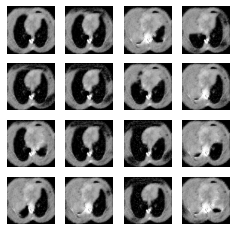

In [246]:
EPOCHS = 50
BATCH_SIZE = 12
train(train_dataset, EPOCHS)

In [247]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [248]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [249]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-i_l6dco_
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-i_l6dco_
  Resolved https://github.com/tensorflow/docs to commit 8890d7fd008d26b8caa2e8e60c895ddbf3ff6ef8


In [250]:
import imageio
import glob
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


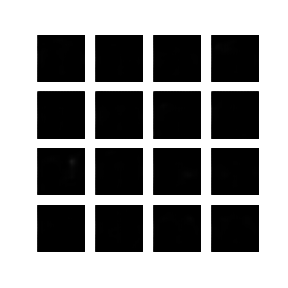

In [251]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

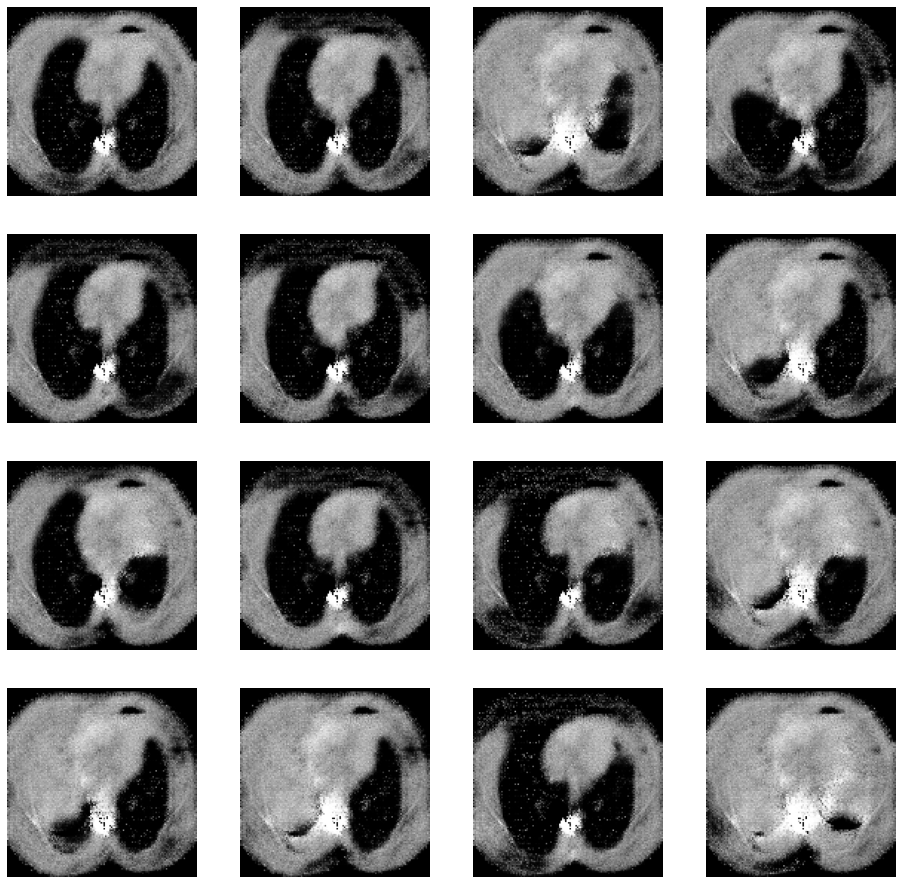

In [252]:
#examine one image
predictions = generator(seed, training=False)

fig = plt.figure(figsize=(16, 16))

for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
plt.show()

In [149]:
!pip install umap-learn

     |████████████████████████████████| 80 kB 6.1 MB/s eta 0:00:011
     |████████████████████████████████| 24.9 MB 17.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 75.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 90.0 MB/s eta 0:00:01
     |████████████████████████████████| 26.3 MB 90.8 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 80.2 MB/s eta 0:00:01
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76564 sha256=210cb5ecc7c539096bd4bce21c58d46c47b0d4b372339e5fef655629b0cf800d
  Stored in directory: /root/.cache/pip/wheels/95/85/b7/b4b7040e49367b6d1505d7e8fb57e3e79b22fa6ac26f72520b
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52373 sha256=8b5499b2d3c9fb9463b83d5b6858e9281f1da88f21ad6b216aac06aa02bba825
  Stored in directory: /root/.cache/pip/wheels/c7/0d/f8/e89d09e0c7419141e444bd59072cc195df4a88785c1052834b
Successfully built umap-learn pynndescent


In [253]:
import umap

In [254]:
reducer = umap.UMAP()

In [255]:
#its a batch of 12, take 5 from it to get 60 images
train_data = []
for data in train_dataset.take(12).as_numpy_iterator():
    for d in data[:,:,:,0]:
        train_data.append(d.flatten())

In [267]:
train_data.shape

(144, 16384)

IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

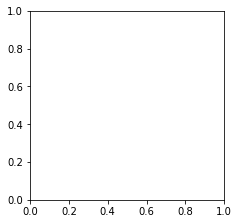

In [266]:
fig = plt.figure(figsize=(16, 16))
for i in range(train_data.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(train_data[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
plt.show()

In [256]:
train_data = np.array(train_data)

In [257]:
train_data.shape

(144, 16384)

In [258]:
num_iter = 10
pred_data = []
for i in range(num_iter):
    predictions = generator(seed, training=False)
    for d in predictions.numpy():
        pred_data.append(d.flatten())

In [259]:
pred_data = np.array(pred_data)
pred_data.shape

(160, 16384)

In [260]:
reducer = umap.UMAP(random_state=42)
reducer.fit(train_data)

UMAP(dens_frac=0.0, dens_lambda=0.0, random_state=42)

In [261]:
embedding = reducer.transform(train_data)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(144, 2)

In [262]:
embedding_pred = reducer.transform(pred_data)

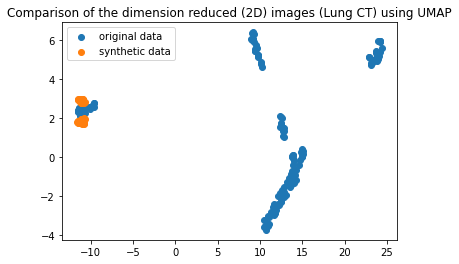

In [263]:
f, a = plt.subplots(1,1)
a.scatter(embedding[:,0],embedding[:,1], label="original data")
a.scatter(embedding_pred[:,0], embedding_pred[:,1], label="synthetic data")
a.legend()
a.set_title("Comparison of the dimension reduced (2D) images (Lung CT) using UMAP")
plt.show()

In [215]:
#test layers
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(32*32*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((32, 32, 256)))
    print(model.output_shape)
    assert model.output_shape == (None, 32, 32, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    print(model.output_shape)
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    print(model.output_shape)
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    print(model.output_shape)
    assert model.output_shape == (None, 128, 128, 1)
    return model

In [ ]:
# def make_generator_model():
#     model = tf.keras.Sequential()
#     model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

#     model.add(layers.Reshape((7, 7, 256)))
#     assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

#     model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
#     assert model.output_shape == (None, 7, 7, 128)
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

#     model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#     assert model.output_shape == (None, 14, 14, 64)
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

#     model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
#     assert model.output_shape == (None, 28, 28, 1)

#     return model

(None, 32, 32, 256)
(None, 32, 32, 128)
(None, 64, 64, 64)
(None, 128, 128, 1)


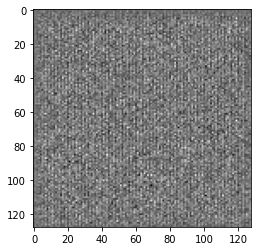

In [224]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [225]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [226]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00084152]], shape=(1, 1), dtype=float32)


In [ ]:
# def make_discriminator_model():
#     model = tf.keras.Sequential()
#     model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
#                                      input_shape=[28, 28, 1]))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     model.add(layers.Flatten())
#     model.add(layers.Dense(1))

#     return model

In [227]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00079893]], shape=(1, 1), dtype=float32)


In [228]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [229]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [230]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [231]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)